# Lab 1: Teacher-Student estimation problem

We study the generalization error dynamics in a shallow linear neural network receiving $n$-dimensional inputs. We consider a standard student-teacher formulation.


Import the libraries

In [1]:
import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
seed = 79790
torch.manual_seed(seed) # set the seed of the random generator

**Teacher model**

The teacher implements a noisy linear mapping between $N$ inputs $x_i\in\mathbb{R}^n$:
\begin{equation}
y_i=x_i^T\beta+\varepsilon_i=\sum_{j=1}^{n}x_{i,j}\beta_j+\varepsilon_i,\:i=1,\ldots,N.
\end{equation}
We assume that the inputs $x_{i,j}$ are drawn i.i.d. from a Gaussian with mean zero and variance $\frac{1}{n}$ so that each example will have an expected norm of one: $\mathbb{E}({\left\lVert x_i\right\rVert}^2_2)= 1$. 

In matrix form, we get
\begin{equation}\label{eq:teacher-mechanism}
y = S\beta+\varepsilon
\end{equation}
where the $i$-th row of $S \in \mathbb{R}^{N\times n}$ is $x_i^T$, $y=(y_1,\ldots,y_N) \in \mathbb{R}^{N}$ and $\varepsilon=(\varepsilon_1,\ldots,\varepsilon_N) \in \mathbb{R}^{N}$. We assume that $N>n$ and that $S$ is a full column rank matrix.

In the equation above, $\varepsilon$ denotes noise in the teacher’s output. We will model both the noise $\varepsilon_i$ and the teacher weights $\beta_j$ as drawn i.i.d. from a random Gaussian distribution with zero mean and variance $\sigma^2_{\varepsilon}$ and $\sigma^2_{\beta}$ respectively. 



### Question 1: Code the teacher data generation mechanism in Pytorch. Use the tensors of Pytorch to store the training data $S$ and $y$. You will take on $n=4$, $N=20$, $\sigma_{\beta}=0.7$, and $\sigma_{\varepsilon}=1.5$.

In [3]:
# Write your code here.

Teacher parameters

In [4]:
N = 20 # number of samples for the training
n = 4 # Dimension of the input
sigma_beta = 0.7  # initialization of the teacher
sigma_epsilon = 1.5 # initialization of the noise


Generate the dataset S of inputs

In [5]:
S = 1/np.sqrt(n)*torch.randn(N, n)

# compute the norm of the square rows
sumS2 = torch.sum(S**2, 1)
print(sumS2.mean())

tensor(0.9871)


Generate $\beta$

In [6]:
beta = sigma_beta*torch.randn(n,1)
print(np.squeeze(beta))

tensor([-1.2990,  1.1700,  0.5823, -0.6471])


Generate the noise $\varepsilon$

In [7]:
epsilon = sigma_epsilon*torch.randn(N,1)
print(epsilon.shape)

torch.Size([20, 1])


Generate the outputs

In [8]:
y = torch.mm(S,beta)+epsilon
print(y.shape)

torch.Size([20, 1])


**Student model**

The student network with weight vector $w \in \mathbb{R}^{n}$ is trained on examples $x_i$ generated by a teacher network:

$$
\hat{y}_i=x_i^\top w.
$$

**Training the student model**

The student network is trained using the dataset $\{y,S\}$ to accurately predict outputs for novel inputs $x \in \mathbb{R}^n$ . 
The student is a shallow linear network, such that the student’s prediction $\hat{y}\in\mathbb{R}$ is simply $\hat{y}=x^Tw$. 

To learn its parameters, the student network will attempt to minimize the mean squared error on the $N$ training samples using gradient descent. The training error is
\begin{equation}\label{eq:train-error}
E_r(w)=\frac{1}{N}\sum_{i=1}^{N}{( y_i -  \hat{y}_i)}^2=\frac{1}{N}\sum_{i=1}^{N}{( y_i -  x_i^T w)}^2=\frac{1}{N}{\left\lVert y -  Sw \right\rVert}^2_2.
\end{equation}



### Question 2: Write $E_r(w)$ under the form 
\begin{equation}
E_r(w)=\frac{1}{N}{\left\lVert y -  Sw \right\rVert}^2_2.
\end{equation}

Write your answer here.

The rewriting is straightforward.

### Question 3: Calculate the gradient of $E_r(w)$ with respect to $w$. Write the gradient in matrix form.

Write your answer here.

The gradient is

$$
\nabla E_r(w)=\frac{2}{N}\left(S^\top Sw-S^\top y\right)
$$

### Question 4: What is the minimum value of $E_r(w)$? This value is denoted $E_r^*$.

Write your answer here.

The optimal value $w^*$ is given by $\nabla E_r(w^*)=0$, i.e.,

$$
w^* = {\left( S^\top S \right)}^{-1}S^\top y
$$

Hence, $E_r^*=\frac{1}{N}{\left\lVert y -  Sw^* \right\rVert}^2_2=\frac{1}{N}{\left\lVert y -  S{\left( S^\top S \right)}^{-1}S^\top y \right\rVert}^2_2$

### Question 5: Compute the optimal weights $w^*$ such that $E_r(w^*)=E_r^*$ and $E_r^*$.

In [9]:
# Write your code here.

Optimal solution which minimizes the train error

In [10]:
# Compute the optimal estimate (this is the optimal linear estimate on the train set)
Stra = S.t() # transpose the matrix S
wstar = torch.inverse(Stra.mm(S)).mm(Stra).mm(y).view(-1,1).detach().numpy()
print('wstar=', np.squeeze(wstar))
ErStar = 1 / N * np.sum((S.detach().numpy().dot(wstar)-y.detach().numpy())**2) 
print('ErStar=', ErStar)

wstar= [-1.0798115   0.04110865  0.9907534  -1.6747283 ]
ErStar= 1.677614974975586


**Generalization error**

We will study the generalization error
\begin{equation}
E_g(t)=E_g(w(t))=\mathbb{E}_{X,Y}{\left(Y-X^Tw(t)\right)}^2=\mathbb{E}_{X,\varepsilon}{\left(X^T\beta+\varepsilon-X^Tw(t)\right)}^2,
\end{equation}
where $w(t)$ is the student weight estimated at time $t$ during the gradient descent and $\varepsilon$ is a random value following a Gaussian distribution with zero mean and variance $\sigma^2_{\varepsilon}$.



### Question 6: What is the oracle error $E_\infty=\mathbb{E}_{X,Y}{\left(Y-X^Tw(t)\right)}^2$ when $w(t)=\beta$ ?

Write your answer here.

It is

$$
E_\infty=\mathbb{E}_{X,\varepsilon}{\left(\varepsilon\right)}^2=\sigma^2_{\varepsilon}.
$$

### Question 7: Generate an evaluation dataset with 10 000 teacher samples. This dataset will be used to compute the evaluation error of the trained student network during the training.

In [11]:
# Write your code here.

Evaluation dataset

In [12]:
evalN = 10000 # number of samples for the evaluation

evalS = 1/np.sqrt(n)*torch.randn(evalN, n)
evalEpsilon = sigma_epsilon*torch.randn(evalN,1)
eval_y = torch.mm(evalS,beta)+evalEpsilon

print(evalS.shape)

torch.Size([10000, 4])


**Gradient descent**

We will use the full gradient descent algorithm to minimize $E_r(w)$:
\begin{equation}
w_{k+1}=w_{k}-\lambda \nabla E_r(w_{k})
\end{equation}
where $\lambda>0$ is a small constant learning rate.
We assume that the starting weights $w{(0)}_i$ are drawn i.i.d. from a Gaussian with mean zero and variance $\sigma^2_0$. 


### Question 8: Implement a shallow neural network in Pytorch to learn $w$ by minmizing the error. The neural network will have only one fully connected layer with no bias. You will use the SGD optimizer from the library "torch.optim". You will take on $\sigma_{0}=0.2$ and the learning rate should be close to $0.01$. The number of iterations will be close to 2 500. You must compute both the training error (on the training dataset) and the evaluation (on the evaluation dataset).

In [13]:
# Write your code here.

Student parameters

In [14]:
sigma_0 = 0.2 # initialization of the linear layer
mylr = 1e-2 # Learning rate
Niter = 2500 # number of iterations for the neural network training

In [15]:
class OneLayerNet(torch.nn.Module):
    def __init__(self, D_in, D_out, w0):
        """
        In the constructor we instantiate Modules we need and assign them as
        member variables.
        """
        super(OneLayerNet, self).__init__()
        self.linear = torch.nn.Linear(D_in, D_out, bias = False)
        torch.nn.init.normal_(self.linear.weight, mean=0.0, std=w0)
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        y_pred = self.linear(x)
        return y_pred

In [16]:
# Construct our model by instantiating the class defined above
model = OneLayerNet(n, 1, sigma_0)

# check initialization of the linear layer weights
w0 = model.linear.weight.data.numpy().reshape(-1,1).copy()
print(w0.mean())
print(w0.std()) 

# Check there is no bias
print(model.linear.bias)

0.018693041
0.08331884
None


Test how the model is running

In [17]:
y_pred = model(S)
print(S.shape)
print(y_pred.shape)

torch.Size([20, 4])
torch.Size([20, 1])


In [18]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters which are members of the model.

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=mylr)

In [19]:
Wt = np.zeros((Niter,n)) # save the estimates of the weights
Lt = np.zeros((Niter,1)) # save the loss
eval_Lt = np.zeros((Niter,1)) # save the evaluation loss

# Training loop
for t in range(Niter):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(S)
    
    wt = model.linear.weight.data.numpy().copy()
    Wt[t,:]=wt

    # Compute and print loss
    loss = criterion(y_pred, y)
    Lt[t] = loss.detach().numpy()
    
    # Evaluation of the expected error
    eval_y_pred = model(evalS)
    eval_loss = criterion(eval_y_pred, eval_y)
    eval_Lt[t] = eval_loss.detach().numpy()
    
    if t % (200) == 0:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



0 3.0551300048828125
200 1.8270028829574585
400 1.7312285900115967
600 1.702581763267517
800 1.6896015405654907
1000 1.6833995580673218
1200 1.6804101467132568
1400 1.6789662837982178
1600 1.6782681941986084
1800 1.6779310703277588
2000 1.6777677536010742
2200 1.6776889562606812
2400 1.6776506900787354


### Question 9: Plot the training error $E_r(t)=E_r(w(t))$ as a function of the gradient descent iterates $t=1,2,\ldots$. You can use the libraries ``matplotlib'' and ``numpy'' to plot the error. Plot on the same graph the constant oracle error $E_\infty$ and also the optimal training error $E_r^*$.

In [20]:
# Write your code here.

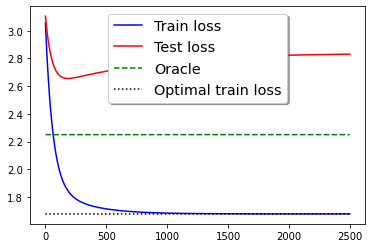

In [21]:
T = range(Niter)
figure = plt.figure()
b1 = plt.plot(T, Lt, 'b-', label='Train loss')
b2 = plt.plot(T, eval_Lt, 'r-', label='Test loss')
b3 = plt.plot(T, (sigma_epsilon**2) * np.ones((Niter,1)), 'g--', label='Oracle')
b5 = plt.plot(T, ErStar * np.ones((Niter,1)), 'k:', label='Optimal train loss')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

EXTRA: We plot the values of $w$ as a function of the gradient steps. We also plot the optimal values for the training dataset.

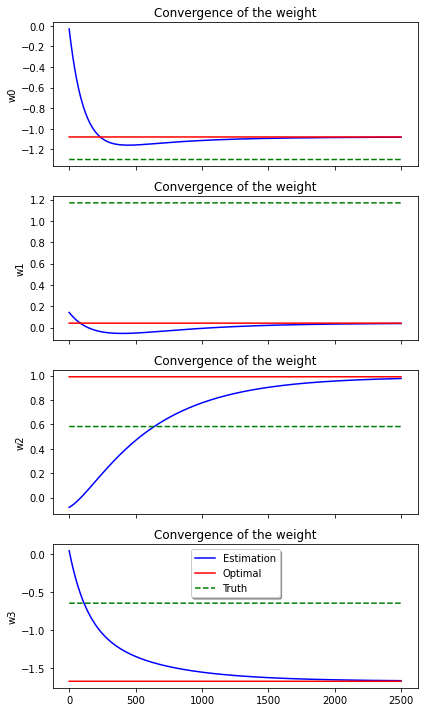

In [22]:
what = Wt[Niter-1,:] # last estimate from the neural network
fig, axs = plt.subplots(n,  sharex=True, figsize = (6,10))
for i in range(n):
    axs[i].set_ylabel("w"+str(i))
    axs[i].plot(T, Wt[:,i], 'b-', label='Estimation')
    axs[i].plot(T, wstar[i]*np.ones((Niter,1)), 'r-' , label='Optimal')
    axs[i].plot(T, beta[i]*np.ones((Niter,1)), 'g--', label='Truth')
    axs[i].set_title('Convergence of the weight')
fig.tight_layout()
plt.legend(loc='upper center', shadow=True)
plt.show()

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

### Question 10: As shown in the lecture, the gradient descent trajectory is approximated by the solution of 
\begin{equation}
	\tau\, \dot{w}(t) = S^Ty-S^TSw(t)
\end{equation}
with $\tau=\frac{N}{2}$.

By using an appropriate change of variables, we get $n$ uncoupled differential equations
$$
\tau \dot{z}_i(t)=(\delta_i-z_i(t)) \lambda_i+\gamma_i \sqrt{\lambda_i}
$$

Their solutions are

$$
z_i(t)=\delta_i+(z_i(0)-\delta_i)e^{-\frac{\lambda_i}{\tau}t}+\frac{\gamma_i}{\sqrt{\lambda_i}}(1-e^{-\frac{\lambda_i}{\tau}t})
$$

where $S^\top S=V\Lambda V^\top$, $z=V^\top w$, $\delta=V^\top \beta$ and $\gamma=\Lambda^{-\frac{1}{2}}V^\top S^\top\varepsilon$. The diagonal elements of $\Lambda$ are the eigenvalues $\lambda_i$.

All the notations are defined in the lecture.

Compute the $n$ functions $z_i(t)$ for $t=k \lambda$ where $k=0,1,\ldots,N$
	

In [23]:
# Write your code here.

In [24]:
Snp = S.numpy()
L, V = np.linalg.eig( (Snp.T).dot(S)) # diagonalization
Lambda = np.diag(L)
Lvector = L.reshape(-1,1)

StSa = (V).dot(Lambda.dot(V.T))


delta = (V.T).dot(beta.numpy())

gamma = np.diag(1./np.sqrt(L)).dot(V.T).dot(S.T).dot(epsilon.numpy())

z0 = V.T.dot(w0) # Initial conditions on $z$

# Value of tau
tau = N/2

# Time samples
t = np.arange(Niter).reshape(1,-1)*mylr

# Compute the uncoupled solutions
z = delta + (z0-delta)*np.exp(-Lvector/tau*np.squeeze(t))+gamma/np.sqrt(Lvector)*(1-np.exp(-Lvector/tau*np.squeeze(t)))


### Question 11: Compute the coupled trajectories $w(t)=Vz(t)$.

In [25]:
# Write your code here.

In [26]:
wsol = V.dot(z)
print(wsol.shape)

(4, 2500)


### Question 12: Plot the empirical learned weights together with the approximated analytic solution $w(t$ as a function of the gradient descent iterates $t=1,2,\ldots$. Plot on the same graph the true coefficients $\beta$, the optimal training weights $w^*$ and the initial weight $w(0)$.

In [27]:
# Write your code here.

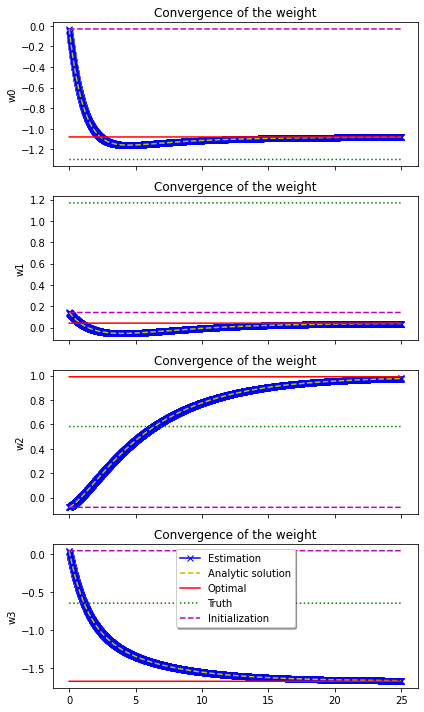

In [28]:
tx = np.squeeze(t) # just manage the dimension of t

what = Wt[Niter-1,:] # last estimate from the neural network
fig, axs = plt.subplots(n,  sharex=True, figsize = (6,10))
for i in range(n):
    axs[i].set_ylabel("w"+str(i))
    axs[i].plot(tx, Wt[:,i], 'b-x', label='Estimation')
    axs[i].plot(tx, wsol[i,:], 'y--', label='Analytic solution')
    axs[i].plot(tx, wstar[i]*np.ones((Niter,1)), 'r-' , label='Optimal')
    axs[i].plot(tx, beta[i]*np.ones((Niter,1)), 'g:', label='Truth')
    axs[i].plot(tx, w0[i]*np.ones((Niter,1)), 'm--', label='Initialization')
    axs[i].set_title('Convergence of the weight')
fig.tight_layout()
plt.legend(loc='upper center', shadow=True)
plt.show()

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()